In [1]:
import keras
import numpy as np
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,GRU,Input,TimeDistributed
from keras.layers.embeddings import Embedding
import matplotlib as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
import string
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.cross_validation import train_test_split
from tensorflow.contrib import learn
import os
from collections import defaultdict
from gensim import corpora

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
def clean_str(string, TREC=False):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Every dataset is lower cased except for TREC
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s ", string)
    string = re.sub(r"\'ve", " have ", string)
    string = re.sub(r"n\'t", " not ", string)
    string = re.sub(r"\'re", " are ", string)
    string = re.sub(r"\'d" , " would ", string)
    string = re.sub(r"\'ll", " will ", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
#   string = re.sub(r"[^\d\.]","",string)
#   string = re.sub(r"[a-zA-Z]{4,}", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip() if TREC else string.strip().lower()

In [7]:
def get_rawdata(filename):
    df=pd.read_csv(filename,encoding='latin-1')
    raw=df['TEXT']
    EXT=pd.get_dummies(df['cEXT'])['y'].as_matrix()
    NEU=pd.get_dummies(df['cNEU'])['y'].as_matrix()
    AGR=pd.get_dummies(df['cAGR'])['y'].as_matrix()
    CON=pd.get_dummies(df['cCON'])['y'].as_matrix()
    OPN=pd.get_dummies(df['cOPN'])['y'].as_matrix()
    EXT=EXT.reshape(len(EXT),1)
    NEU=NEU.reshape(len(NEU),1)
    AGR=AGR.reshape(len(AGR),1)
    CON=CON.reshape(len(CON),1)
    OPN=OPN.reshape(len(OPN),1)
    ytrain=np.concatenate((EXT,NEU,AGR,CON,OPN),axis=1)
    return raw,ytrain
    

    

In [8]:
def get_chargedwords(filename):
    df=pd.read_csv(filename,encoding='latin-1')
    emontial=df[df['Charged']!=0]['Words'].tolist()
    return emontial
    

In [72]:
def clean_essay(raw,emontial):
    doc=[]
    sentence_length=[]
    for i in raw:
        essay=re.split(r'[.?!]',i)
        sentences=[]
        for sent in essay:
            sent=clean_str(sent)
            sent=sent.split(' ')
            if(len(sent)>150):
                newsent=[]
                splits=int(np.floor(len(sent)/20))
                for index in range(splits):
                            newsent.append(' '.join(sent[index*20:(index+1)*20]))
                if len(sent)>splits*20:
                            newsent.append(' '.join(sent[splits*20:]))
                for s in newsent:
                    n=0
                    s=s.split(' ')
                    for word in s:
                        if word in emontial:
                            n=n+1
                    if n!=0:
                        sentence_length.append(len(s))
                        s=' '.join(s)
                        sentences.append(s)
                    
            else:
                n=0
                for word in sent:
                    if word in emontial:
                        n=n+1
                if n!=0:
                    sentence_length.append(len(sent))
                    sent=' '.join(sent)
                    sentences.append(sent)    
        doc.append(sentences)
    return doc,max(sentence_length)

In [10]:
def merge_sents(doc):
    b=[]
    for essay in doc:
        for sent in essay:
            b.append(sent)
    return b

In [11]:
[raw,labels]=get_rawdata('essays.csv')

emontial=get_chargedwords('Emotion_Lexicon.csv')

[doc,max_wordNum]=clean_essay(raw,emontial)

merged_essay=merge_sents(doc)



# 1. Get word-embedding matrix from pre-trained model

In [12]:
vocab_processor = learn.preprocessing.VocabularyProcessor(max_wordNum)
vocab_processor.fit_transform(merged_essay)
vocab_dict = vocab_processor.vocabulary_._mapping

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [34]:
def pre_trained_embedding(dictionary,filename):

    embeddings_index = {}
    f = open(filename)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    #print('Found %s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((len(dictionary), 50))
    for word, i in dictionary.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [35]:
M_pre_train=pre_trained_embedding(vocab_dict,'/Users/silver/ML/glove/glove.6B/glove.6B.50d.txt')

In [60]:
#convert text to martix
def text_to_martix(doc):
    data=doc.copy()
    for i in range(len(data)):
        data[i]=np.array(list(vocab_processor.transform(data[i])))
    data=np.array(data)
    numsentences=[]
    for i in range(len(data)):
        numsentences.append(len(data[i]))
    max_sentNum=max(numsentences)
    for i in range(len(data)):
        ess=data[i]
        if len(ess)<max_sentNum:
            zeros=np.zeros([max_sentNum-len(ess),max_wordNum])
            data[i]=np.concatenate((ess,zeros),axis=0)
    return data,max_sentNum

In [61]:
[data,max_sentNum]=text_to_martix(doc)

In [24]:
def data_reshape(data):
    y=np.dstack(data)
    y=np.rollaxis(y,-1)
    return y
#return a martix whose shape is (# of essays,# of sentences,# of words,)

In [37]:
xtrain=data_reshape(data)

In [68]:
embedding_vecor_length = 50
modellstm = Sequential()
modellstm.add(Embedding(len(vocab_dict),embedding_vecor_length,weights=[M_pre_train]
                       ,input_shape=(max_sentNum,max_wordNum),trainable=True,name='Embedding_1'))
#modellstm.add(Dropout(0.2,name='Dropout_in'))
modellstm.add(TimeDistributed(LSTM(128,return_sequences=False),name='LSTM_1'))# 128 could be any integer
#modellstm.add(Dropout(0.2,name='Dropout_LSTM1'))
modellstm.add(LSTM(64,return_sequences=False,name='LSTM_2')) # 64 could be any integer
#modellstm.add(Dropout(0.2,name='Dropout_LSTM2'))
modellstm.add(Dense(15,activation='sigmoid',name='hidden_layer')) # 15 could be any integer
modellstm.add(Dense(5, activation='sigmoid',name='Dense_out')) # 5 responds to 5 personalities
modellstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modellstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_1 (Embedding)      (None, 129, 149, 50)      1282050   
_________________________________________________________________
LSTM_1 (TimeDistributed)     (None, 129, 128)          91648     
_________________________________________________________________
LSTM_2 (LSTM)                (None, 50)                35800     
_________________________________________________________________
hidden_layer (Dense)         (None, 15)                765       
_________________________________________________________________
Dense_out (Dense)            (None, 5)                 80        
Total params: 1,410,343
Trainable params: 1,410,343
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
#don't run this line
history=modellstm.fit(xtrain,labels ,epochs=10, batch_size=200)

Epoch 1/10
2467/2467 [==============================] - 411s 167ms/step - loss: 0.7460 - acc: 0.4958
Epoch 2/10
2467/2467 [==============================] - 395s 160ms/step - loss: 0.7062 - acc: 0.4986
Epoch 3/10
2467/2467 [==============================] - 368s 149ms/step - loss: 0.6944 - acc: 0.5060
Epoch 4/10
2467/2467 [==============================] - 363s 147ms/step - loss: 0.6929 - acc: 0.5143
Epoch 5/10


KeyboardInterrupt: 

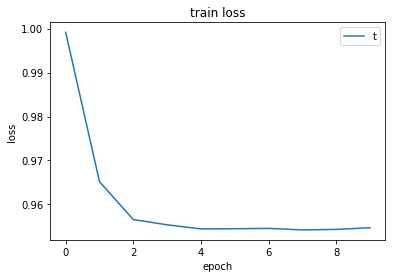

In [53]:
# learning curve
pyplot.plot(history.history['loss'])
#pyplot.plot(history.history['val_loss'])
pyplot.title('train loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend('train loss', loc='upper right')
pyplot.show()